## What is MCMC?
MCMC stands for Monte-Carlo Markov Chains. This is a way to create the PDF(Probability Density Function) of a function, which can be used to evaluate the sensitivity of a model to specific parameters. This is done by creating a Walker that heuristically walks through the parameter space of the model, moving to maximize the likelihood of the model given the data. More intutively, the walker is trying to find the "best" point where height is defined by some cost function. 

To introduce this topic we are going to crawl the function $10*exp(\frac{−(x−3)^2}{5}+\frac{−(y−1)^2}{10})$. Before we do this we need to define out function and graph it beneath to get an idea of its general shape. 

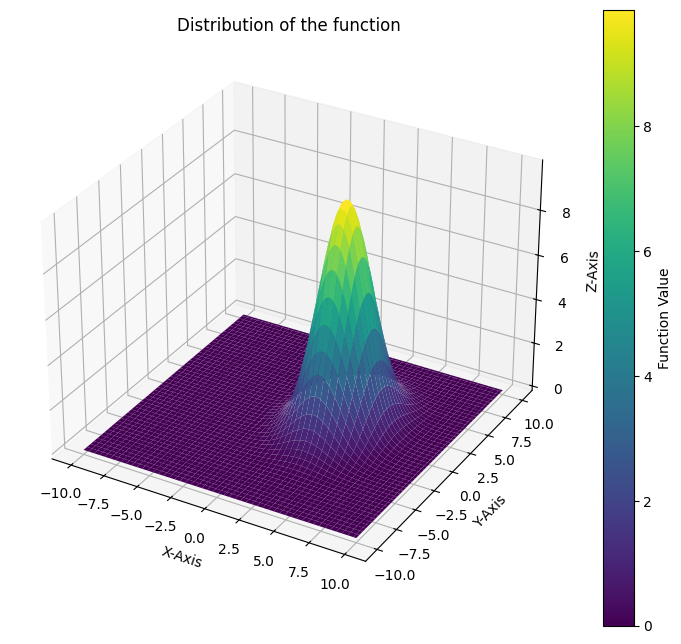

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

#This is the function we are graphing
def f(x, y):
    return 10 * np.exp((-((x - 3)**2))/5 + ((-(y - 1)**2)/10))

#Gets us our x values and our y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

#This is the cartesian product of the two arrays
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

#This graphs the function in the 3D space
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, label='Function Value')
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('Distribution of the function')
plt.show()

Now we are going to create the walker itself. We do this by initializing the walker at some point(in this example we choose (-2,-2), but given enough steps the starting point should not matter). The walker then proposes a new step randomly around it, and evaluates the function at that point. If the function at the new point is greater than the function at the old point, the walker will move to that new point. If it is worse it will compare the ratio of the new point to the old point and move to the new point with a probability of $\frac{new}{old}$. This prevents the walker from getting stuck at local minima, while allowing it to trend towards better points. 
  
Because it has no halting condition we have to specify a number of steps for the walker to take. This is a hyperparameter that can be tuned to get better results.

In [23]:
import seaborn as sns
#a function to return a point around the walker. Which is used to propose a new state
def proposal_distribution(mean, std):
    return np.random.normal(mean, std)

#This is the allows the walker to move around by proposing new states.
def metropolis_hastings(target, proposal, initial_state, num_steps):
    current_state = initial_state[0], initial_state[1],target(initial_state[0],initial_state[1])

    #This is a list containing the locations that the walker has visited
    samples = [current_state]

    
    for i in range(num_steps):
        # Propose a new state randomly around 
        proposed_state = proposal((current_state[0],current_state[1]), std=0.5)  # Adjust std as needed


        acceptance_ratio = min(1, target(proposed_state[0],proposed_state[1]) / target(current_state[0],current_state[1]))

        # Accept or reject the proposed state
        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state[0],proposed_state[1],target(proposed_state[0],proposed_state[1])

        samples.append(current_state)

    return np.array(samples)

# Number of MCMC steps
num_steps = 5000

# Initial state
initial_state = (-2, -2)  # Initial x, y coordinates

# Run Metropolis-Hastings sampler
samples = metropolis_hastings(f, proposal_distribution, initial_state, num_steps)


Now in order to interpret the results from the walker we need to aggregate its steps in some way. To do this we create a KDE of where the walkers has stepped on the x-axis and the y-axis. Notice how this resembles a top down veiw of our original function. Later on with more advanced analysis when we don't know what the "shape" of our function is we can use walkers to get a rough idea of what it looks like.

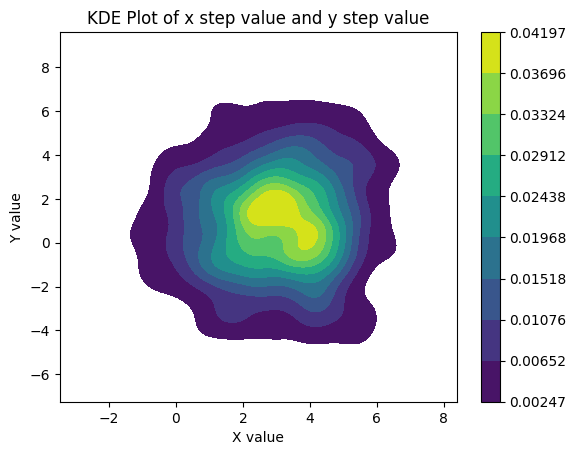

In [24]:
# Extract x and y coordinates from samples
x_samples = samples[:,0]
y_samples = samples[:,1]
z_samples = samples[:,2]

#Makes a KDE plot of the walkers locations
data = pd.DataFrame({'x': x_samples, 'y': y_samples})
sns.kdeplot(data=data, x='x', y='y', cmap='viridis', fill=True,cbar=True)
plt.title('KDE Plot of x step value and y step value')
plt.xlabel('X value')
plt.ylabel('Y value')

plt.show()


While it might not be insanely visible within this example there is a time period where the walker is "burning in". This is when its slowly trending towards the peak of our function, and these steps are not representative of the function. This is because we want the walker to reach the peak and then start exploring the nearby area around it. In order to get a better idea of the function we can just ignore the steps within the burn in period.

Text(0, 0.5, 'X Value')

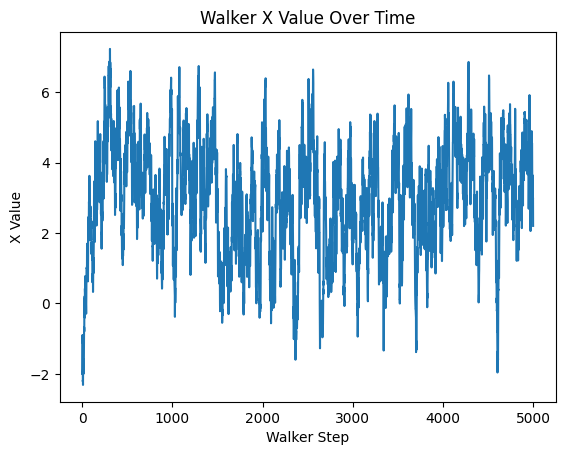

In [25]:
plt.plot(x_samples)
plt.title('Walker X Value Over Time')
plt.xlabel('Walker Step')
plt.ylabel('X Value')

Next we examined the distribution of x and y positions of the walker. This is done by making a histogram of the x and y values of the steps the walker took. Notice how this looks like a normalized version of our original function. 

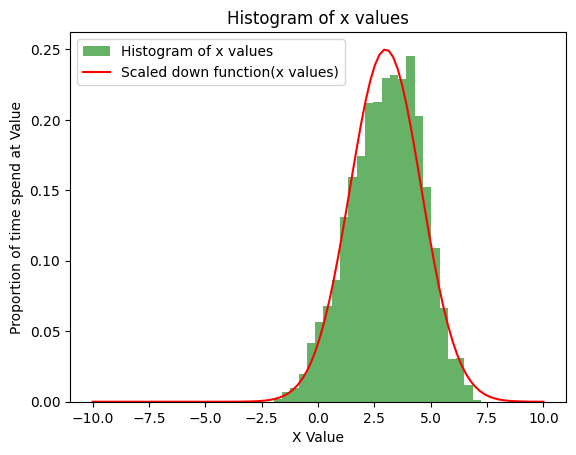

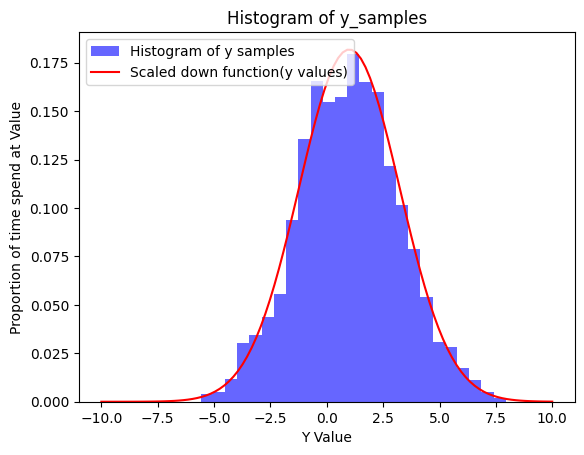

In [26]:
plt.hist(x_samples[200:], bins=25, density=True, alpha=0.6, color='g',label='Histogram of x values')
plt.title('Histogram of x values')
plt.xlabel('X Value')
plt.ylabel('Proportion of time spend at Value')
y_lock=1
x_moving=np.linspace(-10,10,100)
z_result=[]
for x in x_moving:
    z_result.append(f(x,y_lock)/40)
plt.plot(x_moving,z_result,label='Scaled down function(x values)',color='red')
plt.legend()
plt.show()
plt.hist(y_samples[200:], bins=25, density=True, alpha=0.6, color='b',label='Histogram of y samples')
plt.xlabel('Y Value')
plt.ylabel('Proportion of time spend at Value')
plt.title('Histogram of y_samples')
x_lock=3
y_moving=np.linspace(-10,10,100)
z_result=[]
for y in y_moving:
    z_result.append(f(x_lock,y)/55)
plt.plot(y_moving,z_result,color='red',label='Scaled down function(y values)')
plt.legend()
